In [1]:
import numpy as np
import glob
import json
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

# ML libraries
import keras  # to be able to clean session
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.losses import categorical_crossentropy

# Maplotlib configs (mainly to use LaTeX font to have consistent fonts in publication)
import matplotlib
rcparams = {                      
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "lmodern",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],          
    "font.size": 12,
    "legend.fontsize": 12,         
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
}
matplotlib.rcParams.update(rcparams)

/home/evert/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## On the full ('raw') images first; will try compressed & normalized images by Misha later

In [14]:
# Load dataset
building_directories = glob.glob("../../test/easy/*")

img_width = 64
img_height = 64

#img_width = 512
#img_height = 384
num_years = len(np.arange(2012,2018+1))

# We're going to be using gray scale, so last dimension is 1 rather than 3 for RGB
dataset = np.zeros( (len(building_directories), num_years, img_height, img_width, 1) )
#dataset = np.zeros( (len(building_directories), num_years, img_height, img_width, 3) )

print("Dataset consists of %d properties"%dataset.shape[0])

# For storing the true transition years labeled by Chris
true_transition_years = []
# For tracking the property location
building_addresses = []

# Loop over the properties
for d,directory in enumerate(building_directories):
    
    # Extract meta info
    with open(directory + "/metadata.json", "r") as read_file:
        metadata = json.load(read_file)
    building_addresses.append(metadata['address'])
    
    # Extract true transition year
    try:
        with open(directory + "/transition.txt", "r") as read_file:
            data = read_file.read()          
        true_transition_years.append(int(data))
    except:
        true_transition_years.append(int(metadata['reroof_permit_expiration_date'][-4:]))
    
    # Get the images
    for y in range(num_years):
        # Load image, convert to gray scale, discard alpha channel and normalize pixel values
        #dataset[d,y] = np.array(Image.open(directory + "/%s.png"%(2012+y)).convert('LA'))[:,:,:1]/255
        
        img = Image.open(directory + "/%s.png"%(2012+y)).convert('LA')
        img = img.crop((0,0,256,256))
        img.thumbnail((64, 64), Image.ANTIALIAS)
        dataset[d,y] = np.array(img)[:,:,:1]/255
        #dataset[d,y] = np.array(Image.open(directory + "/%s.png"%(2012+y)))[:,:,:3]/255
        
        # Normalize images
        #dataset[d,y] -= dataset[d,y].mean()
        #dataset[d,y] /= dataset[d,y].std()

Dataset consists of 30 properties


### Image demo

2017


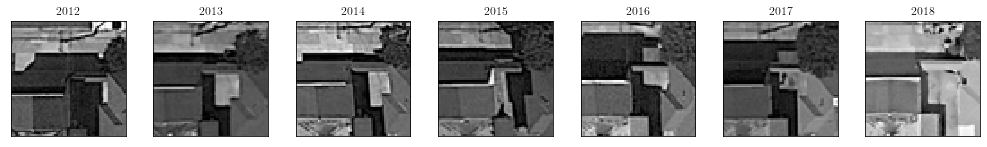

In [15]:
fig, ax = plt.subplots(1,7,figsize=(14,14/7))

build = 9
for i in range(7):
    ax[i].imshow(dataset[build,i][:,:,0], cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(2012 + i)
    
fig.tight_layout()
print(true_transition_years[build])

### Define NN model

In [16]:
def init_NN():
    # Define a NN model
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(10, 10), strides=(5, 5),
                     activation='relu',
                     input_shape=(img_height, img_width, 1)))
   #model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
   # model.add(Conv2D(64, (5, 5), activation='relu'))
   # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss=categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [17]:
testmodel = init_NN()
testmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 11, 11, 16)        1616      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1936)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                19370     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 21,008
Trainable params: 21,008
Non-trainable params: 0
_________________________________________________________________


### Naive confusion, per year and per building

In [18]:
np.random.seed(1990)
num_epochs = 20

# Keep track of the network's accuracy per epoch, per building and per 'guessed' transition year
network_performance_for_building = np.zeros( (dataset.shape[0], num_epochs, num_years))

for transition_year in range(num_years):
    print("Transition year %d"%(transition_year + 2012))
    
    # Create the labels
    labels = np.zeros( (num_years,2) )
    for y in range(num_years):
        labels[y] = [1,0] if y <= transition_year else [0,1]
        
    #
    # Could sample indices here instead of taking the entire dataset
    #
    building_indices = np.arange(dataset.shape[0])

    # New network for every building and every guessed transition year
    for b in building_indices:
        print("\t Considering property number %d out of %d"%(b+1, len(building_indices)))
        NN_model = init_NN()
    
        for e in np.arange(num_epochs):
            # Train the network with this set of labels
            history = NN_model.fit( dataset[b], labels, epochs=1, verbose=0 )
            network_performance_for_building[b,e,transition_year] = np.copy(history.history['acc'][0])
            del history
            
        # Delete object and cross fingers that python GC works 
        del NN_model
        keras.backend.clear_session()

Transition year 2012
	 Considering property number 1 out of 30
	 Considering property number 2 out of 30
	 Considering property number 3 out of 30
	 Considering property number 4 out of 30
	 Considering property number 5 out of 30
	 Considering property number 6 out of 30
	 Considering property number 7 out of 30
	 Considering property number 8 out of 30
	 Considering property number 9 out of 30
	 Considering property number 10 out of 30
	 Considering property number 11 out of 30
	 Considering property number 12 out of 30
	 Considering property number 13 out of 30
	 Considering property number 14 out of 30
	 Considering property number 15 out of 30
	 Considering property number 16 out of 30
	 Considering property number 17 out of 30
	 Considering property number 18 out of 30
	 Considering property number 19 out of 30
	 Considering property number 20 out of 30
	 Considering property number 21 out of 30
	 Considering property number 22 out of 30
	 Considering property number 23 out of 30

	 Considering property number 10 out of 30
	 Considering property number 11 out of 30
	 Considering property number 12 out of 30
	 Considering property number 13 out of 30
	 Considering property number 14 out of 30
	 Considering property number 15 out of 30
	 Considering property number 16 out of 30
	 Considering property number 17 out of 30
	 Considering property number 18 out of 30
	 Considering property number 19 out of 30
	 Considering property number 20 out of 30
	 Considering property number 21 out of 30
	 Considering property number 22 out of 30
	 Considering property number 23 out of 30
	 Considering property number 24 out of 30
	 Considering property number 25 out of 30
	 Considering property number 26 out of 30
	 Considering property number 27 out of 30
	 Considering property number 28 out of 30
	 Considering property number 29 out of 30
	 Considering property number 30 out of 30


### Check progression as fct of epochs

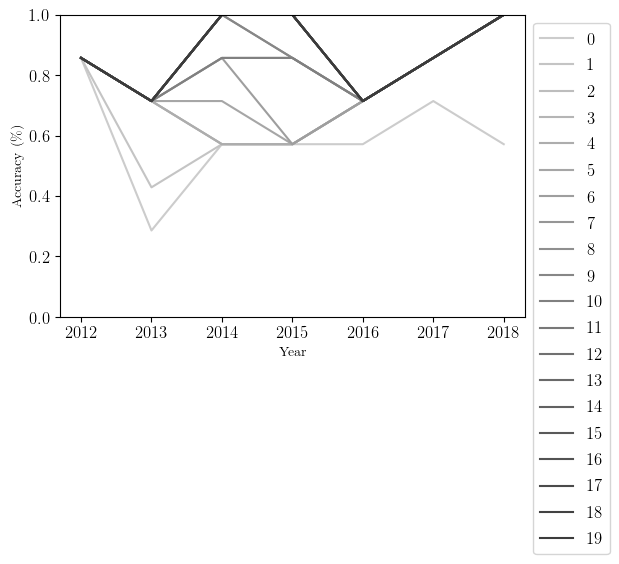

In [19]:
# Pick a building
building = 0

fig, ax = plt.subplots(dpi=100)

for e in range(num_epochs):
    ax.plot( network_performance_for_building[building,e], color=np.array([0.8,0.8,0.8]) - 0.6*e/num_epochs, label="%d"%e )
    
ax.set_ylim([0,1])
ax.set_xticks(range(7))
ax.set_xticklabels(range(2012,2019))
ax.set_xlabel("Year")
ax.set_ylabel("Accuracy (\%)")
ax.legend(fancybox=True, bbox_to_anchor=(0.2,0,1,1))

In [8]:
epoch_to_plot = -1

predicted_transition_years = []
for b in range(dataset.shape[0]):
    ax.plot( network_performance_for_building[b,epoch_to_plot][1:-1], label="%d"%b )
    
    # Chop off the first and last year, those are expected maxima
    transition_indices = np.argwhere(network_performance_for_building[b,epoch_to_plot][1:-1] >= 0.99)
    
    if( len(transition_indices) == 0 ):
        predicted_transition_years.append(2015)
    else:
        transition_years = [range(2013,2018)[transition_indices[y][0]] for y in range(len(transition_indices))]
        index = -1 #int(len(transition_years)/2)
        predicted_transition_years.append(transition_years[index])

In [11]:
print(predicted_transition_years)
print(true_transition_years)

[2016, 2015, 2017, 2015, 2014, 2015, 2015, 2017, 2015, 2015, 2015, 2015, 2015, 2015, 2017, 2016, 2015, 2015, 2016, 2015, 2017, 2015, 2015, 2015, 2015, 2015, 2016, 2015, 2015, 2016, 2015, 2015, 2015, 2017, 2015, 2014, 2015, 2015, 2017, 2015, 2017, 2015, 2015, 2016, 2017, 2016, 2015, 2016, 2015, 2017, 2015, 2015, 2015, 2014, 2015, 2016, 2015, 2015, 2016, 2014, 2015, 2014, 2014, 2016, 2015, 2014, 2015, 2015, 2016, 2015, 2016, 2016, 2015, 2017, 2015, 2015, 2015, 2015, 2015, 2015, 2016, 2016, 2015, 2015, 2016, 2014, 2015, 2016, 2014]
[2017, 2018, 2017, 2018, 2017, 2018, 2017, 2013, 2015, 2015, 2014, 2013, 2018, 2017, 2013, 2016, 2014, 2017, 2016, 2018, 2016, 2017, 2016, 2016, 2017, 2013, 2016, 2013, 2016, 2018, 2016, 2016, 2019, 2014, 2014, 2017, 2017, 2020, 2017, 2016, 2016, 2015, 2020, 2017, 2018, 2016, 2017, 2014, 2016, 2015, 2016, 2018, 2018, 2017, 2016, 2013, 2017, 2020, 2018, 2021, 2018, 2021, 2086, 2016, 2015, 2018, 2015, 2017, 2017, 2018, 2018, 2017, 2017, 2017, 2020, 2018, 2017, 20

#### Write the CSV file

In [13]:
with open('ConfusionTestHard.csv', 'w') as outfile:
    outfile.write("%s,%s,%s\n"%("site_address","transition_true,transition_predicted", "True Transition", "Predicted Transition"))    
    for b in range(dataset.shape[0]):
        outfile.write("\"%s\",%d,%d\n"%(building_addresses[b], true_transition_years[b], predicted_transition_years[b]))    

## One network per year (generalize across buildings?)

In [6]:
np.random.seed(1990)
num_epochs = 10

# Keep track of the network's accuracy per epoch, per building and per 'guessed' transition year
network_performance_for_building = np.zeros( (dataset.shape[0], num_epochs, num_years))

for transition_year in range(num_years):
    print("Transition year %d"%(transition_year + 2012))
    
    # Create the labels
    labels = np.zeros( (num_years,2) )
    for y in range(num_years):
        labels[y] = [1,0] if y <= transition_year else [0,1]
        
    #
    # Could sample indices here instead of taking the entire dataset
    #
    building_indices = np.arange(dataset.shape[0])
    
    NN_model = init_NN()

    for e in np.arange(num_epochs):
        
        for b in building_indices:
            # Train the network with this set of labels
            history = NN_model.fit( dataset[b], labels, epochs=1, verbose=0 )
            network_performance_for_building[b,e,transition_year] = history.history['acc'][0]
            
    # Delete object and cross fingers that python GC works 
    del NN_model

Transition year 2012
Transition year 2013
Transition year 2014
Transition year 2015
Transition year 2016
Transition year 2017
Transition year 2018
